# PowerShell Kernel

The PowerShell kernel is working great on Windows or Linux, and you can use it to produce documentation of your troubleshooting, researching, and even your regular processes, to create visual reports and more.

However, there are a lot of features that aren't finished, and a lot of ideas I'd like feedback on. 

This notebook is a demonstration of features, ways you can use the kernel, and tips and tricks -- but it's also documents the problems in the current version of the kernel and jupyter, and poses questions I'd love feedback on.

### Let's start with the basics: 

It's PowerShell. You can run commands, use variables and pipelines and the text output is just displayed the way you'd expect it to be:

In [2]:
$Files = Get-ChildItem -File
$Files | Sort-Object LastWriteTime -Descending

Directory: /home/jovyan/work


Mode                LastWriteTime         Length Name                                                                   
----                -------------         ------ ----                                                                   
--r---          4/21/18  11:50 PM          41999 LiterateDevOps-Copy1.ipynb                                             
--r---          4/21/18  11:27 PM          42137 LiterateDevOps.ipynb                                                   
--r---          4/20/18   6:34 AM           1546 Dockerfile                                                             
--r---          4/20/18   4:19 AM           2974 build.ps1                                                              
--r---           4/6/18   3:20 AM           4354 LiterateDevOps.md                                                      
--r---           4/6/18   3:20 AM         170560 ReadMe.ipynb                                                           
-

## `Write-Jupyter`

The PowerShell kernel also includes command that directly outputs HTML, markdown, javascript, images, etc. into the Jupyter document.  For example, we could render that ReadMe inline:

In [1]:
Get-Content ReadMe.md | Out-String | Write-Jupyter -MimeType markdown

# A [Jupyter](https://jupyter.org/) Kernel for [PowerShell](https://github.com/PowerShell/PowerShell)

This kernel is being written in C#, and in the process, I've taken some messaging code from the [iCSharp kernel](https://github.com/zabirauf/icsharp) and made a generic library for .Net with a re-usable core for anyone who needs to create [Jupyter](https://jupyter.org/) kernels in .Net languages -- so feel free to borrow that if you like (it's under the Apache license).

## Install

I am finally doing a preliminary release: you can download from the releases link, unzip it somewhere, and run the `Install.ps1` script. Note that if you run this on Linux or OS X you should expect to see only "PowerShell (Core)" but on Windows you'll see both -- but only the "PowerShell (Full)" will actually work unless you have PowerShell Core installed in your PATH and working.

## Current Status

At this point, I'm only handling two messages:

* KernelInfo request
* Execute request

The PowerShell kernel is _working_, and returning text output _and errors_ as on the console (see examples below).

## Features

Apart from the built-in Jupyter features, I'm going to add some output enhancements so you can hook into widgets, etc. However, there's none of that yet, except that:

* If you output HTML, it's rendered. I'm currently detecting this in the most simplistic fashion: by testing if the output starts with "<" and ends with ">". That probably needs work, but it's good enough for now.
* When a command outputs objects, you get the text rendering, but the actual objects are also returned as application/json data.

## PowerShell Core

In order to get cross-platform support, this kernel is based on [PowerShell Core](https://github.com/PowerShell/PowerShell).

To build it yourself --or to run the "PowerShell (Core)" kernel-- you need [dotnet core 2](https://www.microsoft.com/net/core).  You can build it by running `dotnet restore; dotnet build` from the root. If you want to build it in Visual Studio, you need VS 2017 version 15.3 or higher.

## Examples

I have [a version of this document with examples](https://github.com/Jaykul/Jupyter-PowerShell/blob/master/ReadMe.ipynb) in it as a Jupyter Notebook, which mostly works, in read-only mode, on github...


For example: if you take your files and convert them to an HTML table, you can output that table inline. For that to work, you really want to use `ConvertTo-Html -Fragment` to get just the table as output, and then pipe it to `Write-Jupyter` as a single string. Normally, `ConvertTo-Html` outputs one `<tr>` at a time, so we need to use `Out-String` or `-join` to convert it into a single string that we can pipe to `Write-Jupyter`.

of course, we really want the `-Fragment` part to happen automatically. I'll have to add some `profile` support at some point to make that happen, but in the meantime, you can put something like this in a cell near the top, and make it work from then on:

In [19]:
$PSDefaultParameterValues["ConvertTo-Html:Fragment"] = $true

Incidentally, there's one other problem that I just noticed. Currently, `Write-Jupyter` outputs each item as it comes in, and wraps them in a tag, so to get a table to output properly, you need one output string. ConvertTo-Html outputs one `<tr>` at a time, so we need to use `Out-String` or `-join` them all together:

In [21]:
$Files | ConvertTo-Html Mode, LastWriteTime, Name, Length | Out-String | Write-Jupyter -MimeType html

Mode,LastWriteTime,Name,Length
--r---,4/20/18 4:19:33 AM,build.ps1,2974
--r---,4/20/18 6:34:12 AM,Dockerfile,1546
--r---,2/20/18 6:44:41 AM,jupyter-powershell.nuspec,4682
--r---,6/24/17 7:07:27 AM,LICENSE.md,1140
--r---,4/21/18 10:46:19 PM,LiterateDevOps.ipynb,33800
--r---,4/6/18 3:20:07 AM,LiterateDevOps.md,4354
--r---,4/6/18 3:09:39 AM,nteract - plotly.ipynb,12423
--r---,4/6/18 3:20:07 AM,ReadMe.ipynb,170560
--r---,3/4/18 2:39:59 AM,ReadMe.md,2302
--r---,8/4/17 3:19:47 AM,Release.ipynb,8712


Now if you want to get clever, you can dump a little javascript in, to make the table sortable. run this line, and then use your mouse on the headers of the table:

In [22]:
'<script src="https://cdn.rawgit.com/stevesouders/5952488/raw/activetable.js"></script>' | Write-Jupyter -MimeType html

Of course, a better trick would be to make that happen automatically. 

I'll see what I can do about that in the future, because this is starting to feel like a lot of modifications for `ConvertTo-Html` -- I'd love some feedback on this. In the meantime, you can add that script to the defaults for `ConvertTo-Html` like what we did with fragment:

In [24]:
$PSDefaultParameterValues["ConvertTo-Html:Fragment"] = $true
$PSDefaultParameterValues["ConvertTo-Html:PostContent"] = '<script src="https://cdn.rawgit.com/stevesouders/5952488/raw/activetable.js"></script>'

Now you can get a sortable table instantly, by just running ConvertTo-Html.

When I tried this as an example, I remembered another reason why we're going to want a better ConvertTo-Html. It doesn't know anything about which columns should be visible, and it doesn't handle properties that are collections:

In [29]:
Get-Module | ConvertTo-Html | Out-String | Write-Jupyter -MimeType html

LogPipelineExecutionDetails,Name,Path,ImplementingAssembly,Definition,Description,Guid,HelpInfoUri,ModuleBase,PrivateData,Tags,ProjectUri,IconUri,LicenseUri,ReleaseNotes,RepositorySourceLocation,Version,ModuleType,Author,AccessMode,ClrVersion,CompanyName,Copyright,DotNetFrameworkVersion,ExportedFunctions,Prefix,ExportedCmdlets,ExportedCommands,FileList,CompatiblePSEditions,ModuleList,NestedModules,PowerShellHostName,PowerShellHostVersion,PowerShellVersion,ProcessorArchitecture,Scripts,RequiredAssemblies,RequiredModules,RootModule,ExportedVariables,ExportedAliases,ExportedWorkflows,ExportedDscResources,SessionState,OnRemove,ExportedFormatFiles,ExportedTypeFiles
False,Microsoft.PowerShell.Management,/usr/src/jupyter-powershell/Modules/Microsoft.PowerShell.Management/Microsoft.PowerShell.Management.psd1,,,,eefcb906-b326-4e99-9f54-8b4bb6ef3c6d,https://go.microsoft.com/fwlink/?linkid=855958,/usr/src/jupyter-powershell,,System.Collections.Generic.List`1[System.String],,,,,,3.1.0.0,Manifest,PowerShell,ReadWrite,,Microsoft Corporation,Copyright (c) Microsoft Corporation. All rights reserved.,,"System.Collections.Generic.Dictionary`2[System.String,System.Management.Automation.FunctionInfo]",,"System.Collections.Generic.Dictionary`2[System.String,System.Management.Automation.CmdletInfo]","System.Collections.Generic.Dictionary`2[System.String,System.Management.Automation.CommandInfo]",System.Collections.Generic.List`1[System.String],System.Collections.Generic.List`1[System.String],System.Collections.ObjectModel.Collection`1[System.Object],System.Collections.ObjectModel.ReadOnlyCollection`1[System.Management.Automation.PSModuleInfo],,,3.0,None,System.Collections.Generic.List`1[System.String],System.Collections.ObjectModel.Collection`1[System.String],System.Collections.ObjectModel.ReadOnlyCollection`1[System.Management.Automation.PSModuleInfo],,"System.Collections.Generic.Dictionary`2[System.String,System.Management.Automation.PSVariable]","System.Collections.Generic.Dictionary`2[System.String,System.Management.Automation.AliasInfo]","System.Collections.Generic.Dictionary`2[System.String,System.Management.Automation.FunctionInfo]",System.Collections.ObjectModel.ReadOnlyCollection`1[System.String],System.Management.Automation.SessionState,,System.Collections.ObjectModel.ReadOnlyCollection`1[System.String],System.Collections.ObjectModel.ReadOnlyCollection`1[System.String]
False,Microsoft.PowerShell.Utility,/usr/src/jupyter-powershell/Modules/Microsoft.PowerShell.Utility/Microsoft.PowerShell.Utility.psd1,,,,1da87e53-152b-403e-98dc-74d7b4d63d59,https://go.microsoft.com/fwlink/?linkid=855960,/usr/src/jupyter-powershell,,System.Collections.Generic.List`1[System.String],,,,,,3.1.0.0,Manifest,PowerShell,ReadWrite,,Microsoft Corporation,Copyright (c) Microsoft Corporation. All rights reserved.,,"System.Collections.Generic.Dictionary`2[System.String,System.Management.Automation.FunctionInfo]",,"System.Collections.Generic.Dictionary`2[System.String,System.Management.Automation.CmdletInfo]","System.Collections.Generic.Dictionary`2[System.String,System.Management.Automation.CommandInfo]",System.Collections.Generic.List`1[System.String],System.Collections.Generic.List`1[System.String],System.Collections.ObjectModel.Collection`1[System.Object],System.Collections.ObjectModel.ReadOnlyCollection`1[System.Management.Automation.PSModuleInfo],,,3.0,None,System.Collections.Generic.List`1[System.String],System.Collections.ObjectModel.Collection`1[System.String],System.Collections.ObjectModel.ReadOnlyCollection`1[System.Management.Automation.PSModuleInfo],,"System.Collections.Generic.Dictionary`2[System.String,System.Management.Automation.PSVariable]","System.Collections.Generic.Dictionary`2[System.String,System.Management.Automation.AliasInfo]","System.Collections.Generic.Dictionary`2[System.String,System.Management.Automation.FunctionInfo]",System.Collections.ObjectModel.ReadOnlyCollection`1[System.String],System.Management.Automation.SessionState,,System.Colle

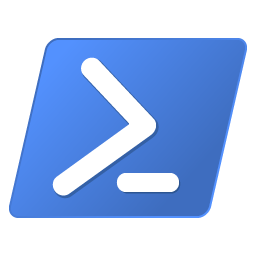

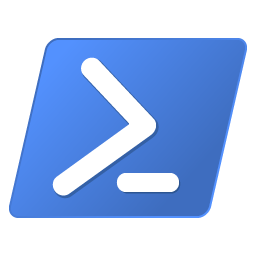

In [30]:
$imageUrl = 'https://upload.wikimedia.org/wikipedia/commons/2/2f/PowerShell_5.0_icon.png'
$ImageData = @{ "png" = (Invoke-WebRequest $imageUrl -UseBasicParsing).RawContentStream.GetBuffer() }
# $ImageData

Write-Jupyter -InputObject $ImageData -Metadata @{ "image/png" = @{ 'width' = 32 } }
Write-Jupyter -InputObject $ImageData -Metadata @{ "image/png" = @{ 'width' = 64 } }